# Data analysis - Timing

Results with ROOT and Scipy

In [1]:
# Import dependecies

import numpy as np
import pandas as pd
import scipy as sp
import ROOT as r
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Serif"
%matplotlib inline

Welcome to JupyROOT 6.26/06


# Process differences of time

Timing pick-off based on LED, IRI and MRI.

In [3]:
from IPython.display import clear_output

# Inputs:
bas_tot = 1000 # Total number of samples for baseline calculation
fl_total = 10 # Total number of files
cw = 1000 # Coincidence window (in samples units)
res = 10 # Time resolution (in ps) from sampling rate

# Pulse processing for each event
# For this test, channels 1 and 3 will be used because the pulses are unipolar
evt_smp = 50000 # Number of samples in an event
evt_acc = 0 # accumulated number of events

evt_total_est = 100 # Total number of events estimative per file (only for specify the length of array)

# Initialize timing arrays
dif_LED = np.zeros(evt_total_est*fl_total) # diference of times of LED method for each event
dif_IRI = np.zeros(evt_total_est*fl_total) # diference of times of IRI method for each event
dif_MRI = np.zeros(evt_total_est*fl_total) # diference of times of IRI method for each event
tLED_error = 0 # Total number of error in method apply
tIRI_error = 0 # Total number of error in method apply
tMRI_error = 0 # Total number of error in method apply
trig_error = 0 # No trigger definition
tout_error = 0 # Out of coincidence window 

# Process each csv file
for chnk in range(fl_total):
    fth_file = "/mnt/e/Documentos/Projetos/python/metacrystal/data/" + str(round(chnk * 0.1 + 0.1, 1)) + "-" + str(round(chnk * 0.1, 1)) + "k.Wfm.csv"    
    df = pd.read_csv(fth_file, encoding ='utf-8', sep=' ') # Data frame from file
    content = df.values # Data frame to Numpy array

    # Each column in Numpy array from Pandas data frame     
    #x0 = np.array(content[:,0]) # Horizontal scale -> T = 0.001E-08 (-5.000E-08 - -4.999E-08) 
    #y0 = np.array(content[:,1]) # Vertical - Signal 0
    y1 = np.array(content[:,1]) # Vertical - Signal 1
    #y2 = np.array(content[:,3]) # Vertical - Signal 2
    y3 = np.array(content[:,3]) # Vertical - Signal 3

    evt_tot = int(len(df.index)/evt_smp) # Total number of events    

    clear_output(wait=False)
    print("File name: {} - Processing {} events...".format(fth_file, evt_tot))    
    
    # Process events
    for evt_nb in range(evt_tot):                       
        evt_sta = evt_nb * evt_smp # Event start
        evt_end = evt_sta + evt_smp - 1 # Event end
        evt_rng = range(evt_sta, evt_end) # Event range

        # Baseline calculation - Average Moving Method
        # In the Average Moving Method, the average is calculated from the beginning 
        # of the event to the sample referring to the trigger.
        # But for simplification, the average will be calculated up to bas_tot sample 
        
        bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
        bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    
        
        # Threshold calculation 
        # For simplification the threshold will be estimed in 6 sigmas aprox.
        thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
        thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

        # Trigger
        try:
            trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample (x axis) for channel 1            
        except StopIteration: # Pulse not identified by threshold
            print("Error in event",evt_acc)
            print("Pulse not identified by threshold")
            trig_error += 1
            continue
        try:
            trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample (x axis) for channel 3
        except StopIteration: # Pulse not identified by threshold
            print("Error in event",evt_acc)
            print("Pulse not identified by threshold")
            trig_error += 1
            continue         

        ## Timing methods:
        # 1- LED (Leading Edge Discrimination)
        # 2- IRI (Initial Rise Interpolation) - https://doi.org/10.1109/NSSMIC.2009.5401926
        # 3- MRI (Maximum Rise Interpolation) - https://doi.org/10.1016/S0168-9002(02)00401-1

        # 1- LED
        with np.errstate(divide='raise'):
            try:
                tLED_t1 = (trg_s1-1 + ((thr_y1 - y1[trg_s1-1]) / (y1[trg_s1] - y1[trg_s1-1]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for LED in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for LED in event ",evt_acc)
                print("Divergent linear interpolation line")
                tLED_error += 1
                continue
        with np.errstate(divide='raise'):
            try:
                tLED_t3 = (trg_s3-1 + ((thr_y3 - y3[trg_s3-1]) / (y3[trg_s3] - y3[trg_s3-1]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for LED in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for LED in event ",evt_acc)
                print("Divergent linear interpolation line")
                tLED_error += 1
                continue      
        
        # 2- IRI
        with np.errstate(divide='raise'):
            try:
                tIRI_t1 = (trg_s1-1 - ((y1[trg_s1-1] - bas_y1) / (y1[trg_s1] - y1[trg_s1-1]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for IRI in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for IRI in event ",evt_acc)
                print("Divergent linear interpolation line")
                tIRI_error += 1
                continue
        with np.errstate(divide='raise'):
            try:
                tIRI_t3 = (trg_s3-1 - ((y3[trg_s3-1] - bas_y3) / (y3[trg_s3] - y3[trg_s3-1]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for IRI in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for IRI in event ",evt_acc)
                print("Divergent linear interpolation line")
                tIRI_error += 1
                continue

        # 3- MRI
        with np.errstate(divide='raise'):
            try:
                tMRI_t1 = (trg_s1 - ((y1[trg_s1] - bas_y1) / (y1[trg_s1+1] - y1[trg_s1]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for MRI in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for MRI in event ",evt_acc)
                print("Divergent linear interpolation line")
                tMRI_error += 1
                continue  
        with np.errstate(divide='raise'):  
            try:  
                tMRI_t3 = (trg_s3 - ((y3[trg_s3] - bas_y3) / (y3[trg_s3+1] - y3[trg_s3]))) * res
            except StopIteration: # Pulse not identified by threshold
                print("Error for MRI in event",evt_acc)
                print("Pulse not identified by threshold")
                trig_error += 1
                continue
            except FloatingPointError: # Divergent linear interpolation line
                print("Error for MRI in event ",evt_acc)
                print("Divergent linear interpolation line")
                tMRI_error += 1
                continue
        
        # Coincidence window
        if abs(tLED_t1 - tLED_t3) > (cw * res):
            tLED_error += 1
            tout_error += 1
            continue
        if abs(tIRI_t1 - tIRI_t3) > (cw * res):
            tIRI_error += 1
            tout_error += 1
            continue
        if abs(tMRI_t1 - tMRI_t3 ) > (cw * res):
            tMRI_error += 1
            tout_error += 1
            continue

        dif_LED[evt_acc] = tLED_t3 - tLED_t1
        dif_IRI[evt_acc] = tIRI_t3 - tIRI_t1 
        dif_MRI[evt_acc] = tMRI_t3 - tMRI_t1 
        
        evt_acc += 1

clear_output(wait=False)
print("Registered events:",evt_acc)
print("Trigger errors:",trig_error)
print("Out of coincidence window:",tout_error)
print("LED errors:",tLED_error)
print("IRI errors:",tIRI_error)
print("MRI errors:",tMRI_error)

Registered events: 961
Trigger errors: 0
Out of coincidence window: 25
LED errors: 24
IRI errors: 1
MRI errors: 14


Choice bin size:

In [4]:
# Input spectra values

# Defining bin sizes: 	
print('Basic:', int(np.round(2*(cw*res)/(res))))
print('Square-root choice:',int(np.round(np.sqrt(evt_acc))))
print('Sturges:', int(np.round(np.log(evt_acc)+1)))
print('Rice:', int(np.round(2*np.cbrt(evt_acc))))
print('Equiprobable:', int(np.round(2*evt_acc**(2/5))))

nbins = int(np.round(2*(cw*res)/(res)))

Basic: 2000
Square-root choice: 31
Sturges: 8
Rice: 20
Equiprobable: 31


# CTR distribution in Matplotlib:

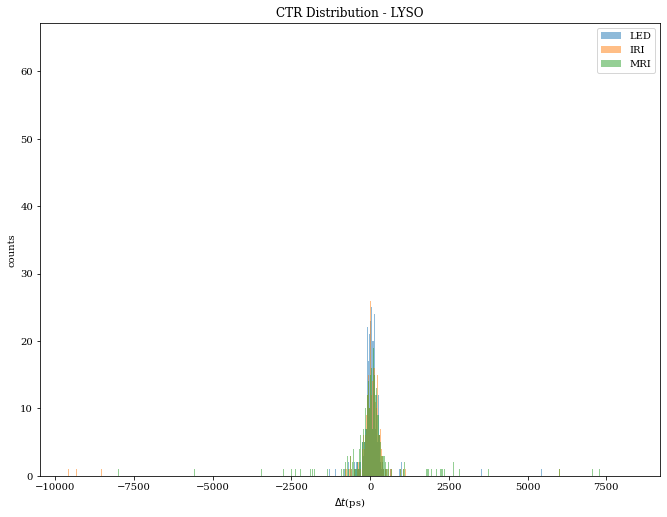

In [5]:
# Load Histogram and Plot in Matplotlib

px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(800*px, 600*px))
plt.title('CTR Distribution - LYSO')
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('counts')
LEDhist, LEDbin, LEDpat = plt.hist(dif_LED, bins=nbins, density=False, alpha=0.5, label='LED')
LEDbin_centers = (LEDbin[1:]+LEDbin[:-1])/2.
IRIhist, IRIbin, IRIpat = plt.hist(dif_IRI, bins=nbins, density=False, alpha=0.5, label='IRI')
IRIbin_centers = (IRIbin[1:]+IRIbin[:-1])/2.
MRIhist, MRIbin, MRIpat = plt.hist(dif_MRI, bins=nbins, density=False, alpha=0.5, label='MRI')
MRIbin_centers = (MRIbin[1:]+MRIbin[:-1])/2.
plt.legend()
plt.show()

# CTR Distribution in ROOT:

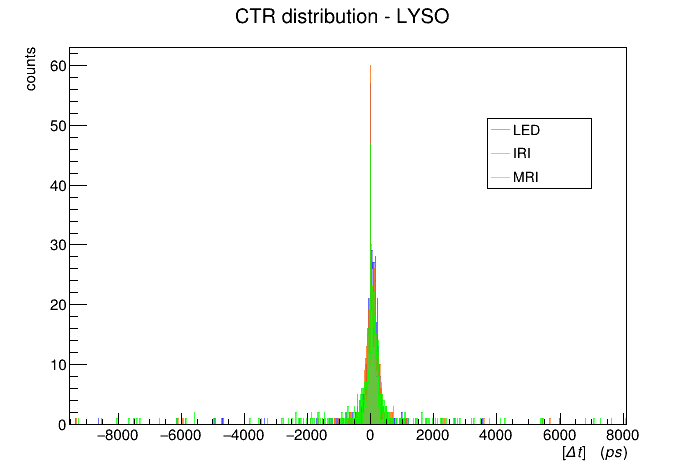

In [6]:
# Load Histogram and Plot in Pyroot
LEDbins = len(LEDbin_centers)
IRIbins = len(IRIbin_centers)
MRIbins = len(MRIbin_centers)

plt.ion()
stack = r.THStack("CTR","CTR distribution - LYSO;$[\Delta t]$(ps);counts")
r.gStyle.SetOptFit(111)
r.TH1.AddDirectory(False); # Remove warning: Potential memory leak

hLED = r.TH1D('hLED','LED histogram', LEDbins-1, LEDbin_centers)
for LEDevt in dif_LED:
    hLED.Fill(LEDevt)
hLED.SetFillColorAlpha(r.kBlue, 0.35)
hLED.SetLineColorAlpha(r.kBlue, 0.35)
stack.Add(hLED)

hIRI = r.TH1D('hIRI','IRI histogram', IRIbins-1, IRIbin_centers)
for IRIevt in dif_IRI:
    hIRI.Fill(IRIevt)
hIRI.SetFillColorAlpha(r.kOrange+7, 0.5)
hIRI.SetLineColorAlpha(r.kOrange+7, 0.5)
stack.Add(hIRI)

hMRI = r.TH1D('hMRI','MRI histogram', MRIbins-1, MRIbin_centers)
for MRIevt in dif_MRI:
    hMRI.Fill(MRIevt)
hMRI.SetFillColorAlpha(r.kGreen, 0.5)
hMRI.SetLineColorAlpha(r.kGreen, 0.5)
stack.Add(hMRI)

legend = r.TLegend (0.7 ,0.6 ,0.85 ,0.75)
legend.AddEntry(hLED ,"LED","L")
legend.AddEntry(hIRI ,"IRI","L")
legend.AddEntry(hMRI ,"MRI","L")
legend.SetLineWidth(1)

c1 = r.TCanvas()
stack.Draw("nostack")
legend.Draw ("same")
c1.Draw()

# Coefficients and covariances in Scipy:

In [7]:
from scipy.optimize import curve_fit

LEDnz = LEDhist>0
IRInz = IRIhist>0
MRInz = MRIhist>0


# Gaussian Fit Function
def gaus(x, const, mu, sigma):
    return const* np.exp(-0.5*((x - mu)/sigma)**2)

p_initial = [150, 200, 30]  # For initial guess

# Define Range and Fit
LEDcoeff, LEDcovar = curve_fit(gaus, LEDbin_centers[LEDnz], LEDhist[LEDnz], p0=p_initial)
IRIcoeff, IRIcovar = curve_fit(gaus, IRIbin_centers[IRInz], IRIhist[IRInz], p0=p_initial)
MRIcoeff, MRIcovar = curve_fit(gaus, MRIbin_centers[MRInz], MRIhist[MRInz], p0=p_initial)

# Coefficients and covariances in ROOT:

In [8]:
hLED.Fit('gaus')
hIRI.Fit('gaus')
hMRI.Fit('gaus')

# Get Root Fit and Goodness of Fit Parameters
fLED = hLED.GetFunction('gaus')
fIRI = hIRI.GetFunction('gaus')
fMRI = hMRI.GetFunction('gaus')
LEDconst,LEDmu,LEDsigma = fLED.GetParameter(0), fLED.GetParameter(1), fLED.GetParameter(2)
LEDeconst,LEDemu,LEDesigma = fLED.GetParError(0), fLED.GetParError(1), fLED.GetParError(2)
LEDndf,LEDchi2,LEDprob = fLED.GetNDF(),fLED.GetChisquare(),fLED.GetProb()
LEDfwhm = 2.355*fLED.GetParameter(2)
LEDefwhm = 2.355*fLED.GetParError(2)

IRIconst,IRImu,IRIsigma = fIRI.GetParameter(0), fIRI.GetParameter(1), fIRI.GetParameter(2)
IRIeconst,IRIemu,IRIesigma = fIRI.GetParError(0), fIRI.GetParError(1), fIRI.GetParError(2)
IRIndf,IRIchi2,IRIprob = fIRI.GetNDF(),fIRI.GetChisquare(),fIRI.GetProb()
IRIfwhm = 2.355*fIRI.GetParameter(2)
IRIefwhm = 2.355*fIRI.GetParError(2)

MRIconst,MRImu,MRIsigma = fMRI.GetParameter(0), fMRI.GetParameter(1), fMRI.GetParameter(2)
MRIeconst,MRIemu,MRIesigma = fMRI.GetParError(0), fMRI.GetParError(1), fMRI.GetParError(2)
MRIndf,MRIchi2,MRIprob = fMRI.GetNDF(),fMRI.GetChisquare(),fMRI.GetProb()
MRIfwhm = 2.355*fMRI.GetParameter(2)
MRIefwhm = 2.355*fMRI.GetParError(2)

 FCN=173.203 FROM MIGRAD    STATUS=CONVERGED     107 CALLS         108 TOTAL
                     EDM=6.70018e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.98603e+01   9.45880e-01   4.45652e-03   2.46928e-06
   2  Mean         4.41849e+01   5.27920e+00   3.38336e-02   1.29776e-07
   3  Sigma        1.47232e+02   5.01448e+00   2.37442e-05  -2.96765e-04
 FCN=224.151 FROM MIGRAD    STATUS=CONVERGED     472 CALLS         473 TOTAL
                     EDM=1.71913e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.84233e+01   9.21213e-01   4.85283e-03  -2.29657e-04
   2  Mean         4.64487e+01   5.48055e+00   3.98018e-02   7.54925e-05
   3  Sigma        1.48863e+02   

Chi sq, Chi2/n, Prob and FWHM calculation:

In [9]:
# Define Fit Curves 
LEDx = LEDbin_centers
LEDroot_gaus = (LEDconst,LEDmu,LEDsigma)
LEDopti_gaus = LEDcoeff

# Calculate chi Squared
fLED_root = gaus(LEDx,*LEDroot_gaus)
fLED_opti = gaus(LEDx,*LEDopti_gaus)
LEDch2_root = np.sum((LEDhist[LEDnz]-fLED_root[LEDnz])**2/LEDhist[LEDnz])
LEDch2_opti = np.sum((LEDhist[LEDnz]-fLED_opti[LEDnz])**2/LEDhist[LEDnz])

# Calculate Degrees of Freedom with 3 fit parameters
LEDdof = len(LEDx[LEDnz])-3

# Calculate Probability
pLED_root = sp.stats.chi2.sf(LEDch2_root, LEDdof)
pLED_opti = sp.stats.chi2.sf(LEDch2_opti, LEDdof)

# Errors
LEDperrs = np.sqrt(np.diag(LEDcovar))

# Calculate FWHM
LEDfwhm_root = 2*np.sqrt(2*np.log(2))*LEDsigma
LEDefwhm_root = 2*np.sqrt(2*np.log(2))*LEDesigma
LEDfwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(LEDcoeff[2])
LEDefwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(LEDperrs[2])

print('LED:')
print('---')
print('Hist\tLibrary\tChi Sq\tChi2/dof\tprob\tFWHM')
print('Root\tRoot\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(LEDchi2, LEDchi2/LEDdof, LEDprob, LEDfwhm, LEDefwhm))
print('Root\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(LEDch2_root, LEDch2_root/LEDdof, pLED_root, LEDfwhm_root, LEDefwhm_root))
print('Scipy\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(LEDch2_opti, LEDch2_opti/LEDdof, pLED_opti, LEDfwhm_opti, LEDefwhm_opti))
print('---')
print('Degrees of Freedom =\t{0}'.format(str(LEDdof)))

LED:
---
Hist	Library	Chi Sq	Chi2/dof	prob	FWHM
Root	Root	173.20	1.18		0.0767	346.7 +/- 11.8 ps
Root	Python	221.87	1.51		0.0001	346.7 +/- 11.8 ps
Scipy	Python	242.42	1.65		0.0000	329.7 +/- 17.1 ps
---
Degrees of Freedom =	147


In [10]:
# Define Fit Curves 
IRIx = IRIbin_centers
IRIroot_gaus = (IRIconst,IRImu,IRIsigma)
IRIopti_gaus = IRIcoeff

# Calculate chi Squared
fIRI_root = gaus(IRIx,*IRIroot_gaus)
fIRI_opti = gaus(IRIx,*IRIopti_gaus)
IRIch2_root = np.sum((IRIhist[IRInz]-fIRI_root[IRInz])**2/IRIhist[IRInz])
IRIch2_opti = np.sum((IRIhist[IRInz]-fIRI_opti[IRInz])**2/IRIhist[IRInz])

# Calculate Degrees of Freedom with 3 fit parameters
IRIdof = len(IRIx[IRInz])-3

# Calculate Probability
pIRI_root = sp.stats.chi2.sf(IRIch2_root, IRIdof)
pIRI_opti = sp.stats.chi2.sf(IRIch2_opti, IRIdof)

# Errors
IRIperrs = np.sqrt(np.diag(IRIcovar))

# Calculate FWHM
IRIfwhm_root = 2*np.sqrt(2*np.log(2))*IRIsigma
IRIefwhm_root = 2*np.sqrt(2*np.log(2))*IRIesigma
IRIfwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(IRIcoeff[2])
IRIefwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(IRIperrs[2])

print('IRI:')
print('---')
print('Hist\tLibrary\tChi Sq\tChi2/dof\tprob\tFWHM')
print('Root\tRoot\t{0:.2f}\t{1:.2f}\t\t{2:.3f}\t{3:.1f} +/- {4:.1f} ps'.format(IRIchi2, IRIchi2/IRIdof, IRIprob, IRIfwhm, IRIefwhm))
print('Root\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.3f}\t{3:.1f} +/- {4:.1f} ps'.format(IRIch2_root, IRIch2_root/IRIdof, pIRI_root, IRIfwhm_root, IRIefwhm_root))
print('Scipy\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.3f}\t{3:.1f} +/- {4:.1f} ps'.format(IRIch2_opti, IRIch2_opti/IRIdof, pIRI_opti, IRIfwhm_opti, IRIefwhm_opti))
print('---')
print('Degrees of Freedom =\t{0}'.format(str(IRIdof)))

IRI:
---
Hist	Library	Chi Sq	Chi2/dof	prob	FWHM
Root	Root	224.15	1.38		0.001	350.6 +/- 12.6 ps
Root	Python	202.16	1.24		0.020	350.5 +/- 12.6 ps
Scipy	Python	213.93	1.31		0.005	344.2 +/- 18.0 ps
---
Degrees of Freedom =	163


In [11]:
# Define Fit Curves 
MRIx = MRIbin_centers
MRIroot_gaus = (MRIconst,MRImu,MRIsigma)
MRIopti_gaus = MRIcoeff

# Calculate chi Squared
fMRI_root = gaus(MRIx,*MRIroot_gaus)
fMRI_opti = gaus(MRIx,*MRIopti_gaus)
MRIch2_root = np.sum((MRIhist[MRInz]-fMRI_root[MRInz])**2/MRIhist[MRInz])
MRIch2_opti = np.sum((MRIhist[MRInz]-fMRI_opti[MRInz])**2/MRIhist[MRInz])

# Calculate Degrees of Freedom with 3 fit parameters
MRIdof = len(MRIx[MRInz])-3

# Calculate Probability
pMRI_root = sp.stats.chi2.sf(MRIch2_root, MRIdof)
pMRI_opti = sp.stats.chi2.sf(MRIch2_opti, MRIdof)

# Errors
MRIperrs = np.sqrt(np.diag(MRIcovar))

# Calculate FWHM
MRIfwhm_root = 2*np.sqrt(2*np.log(2))*MRIsigma
MRIefwhm_root = 2*np.sqrt(2*np.log(2))*MRIesigma
MRIfwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(MRIcoeff[2])
MRIefwhm_opti = 2*np.sqrt(2*np.log(2))*np.abs(MRIperrs[2])

print('MRI:')
print('---')
print('Hist\tLibrary\tChi Sq\tChi2/dof\tprob\tFWHM')
print('Root\tRoot\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(MRIchi2, MRIchi2/MRIdof, MRIprob, MRIfwhm, MRIefwhm))
print('Root\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(MRIch2_root, MRIch2_root/MRIdof, pMRI_root, MRIfwhm_root, MRIefwhm_root))
print('Scipy\tPython\t{0:.2f}\t{1:.2f}\t\t{2:.4f}\t{3:.1f} +/- {4:.1f} ps'.format(MRIch2_opti, MRIch2_opti/MRIdof, pMRI_opti, MRIfwhm_opti, MRIefwhm_opti))
print('---')
print('Degrees of Freedom =\t{0}'.format(str(MRIdof)))

MRI:
---
Hist	Library	Chi Sq	Chi2/dof	prob	FWHM
Root	Root	303.99	1.22		0.0061	429.1 +/- 20.3 ps
Root	Python	305.77	1.23		0.0081	429.1 +/- 20.3 ps
Scipy	Python	331.68	1.33		0.0004	379.5 +/- 17.8 ps
---
Degrees of Freedom =	249


# Plot CTR distribution with gaussian fit:

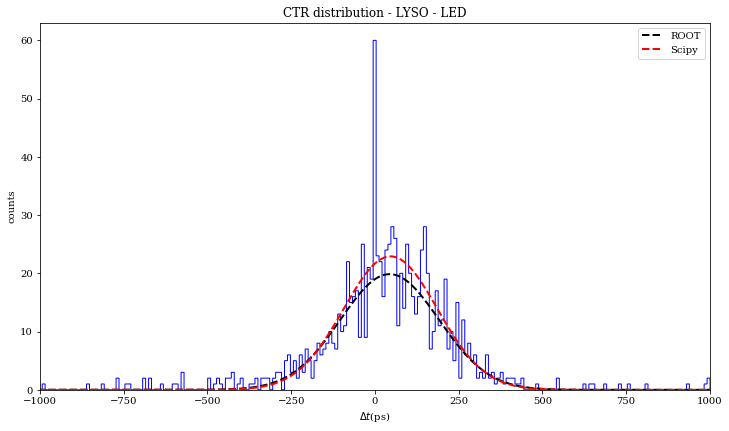

In [12]:
fig, ax = plt.subplots(figsize=(12,6.75))

plt.stairs(LEDhist, LEDbin, color='blue')
plt.plot(LEDx, fLED_root, 'k--', linewidth=2, label='ROOT')
plt.plot(LEDx, fLED_opti, 'r--', linewidth=2, label='Scipy')
plt.xlim(-1000, 1000)
# plt.savefig('python_fit.png', dpi=300)
plt.title('CTR distribution - LYSO - LED')
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('counts')
plt.legend()
plt.show()

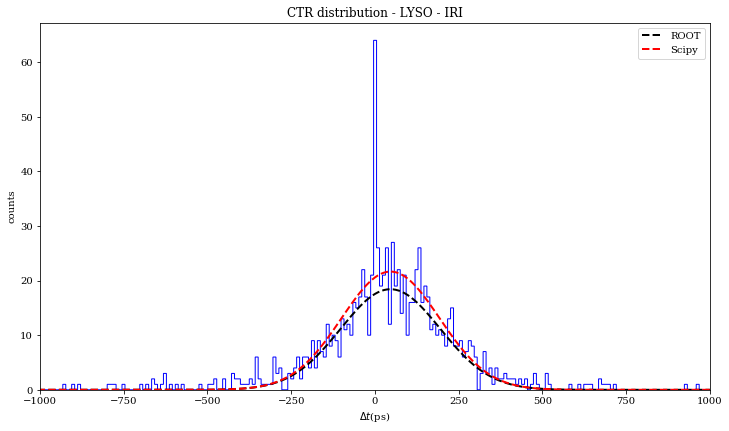

In [13]:
fig, ax = plt.subplots(figsize=(12,6.75))

plt.stairs(IRIhist, IRIbin, color='blue')
plt.plot(IRIx, fIRI_root, 'k--', linewidth=2, label='ROOT')
plt.plot(IRIx, fIRI_opti, 'r--', linewidth=2, label='Scipy')
plt.xlim(-1000, 1000)
# plt.savefig('python_fit.png', dpi=300)
plt.title('CTR distribution - LYSO - IRI')
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('counts')
plt.legend()
plt.show()

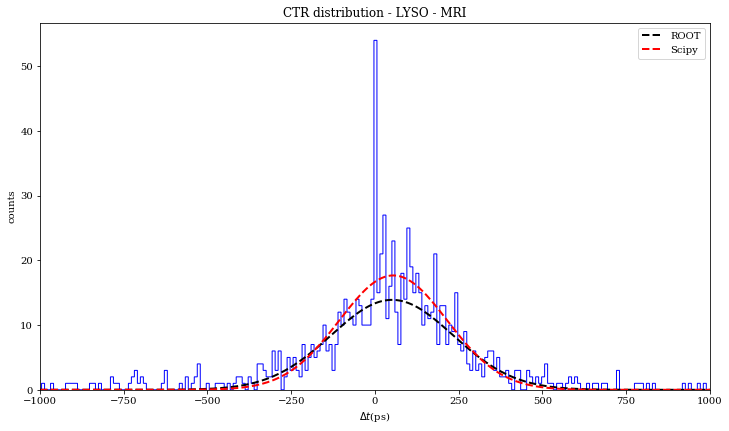

In [14]:
fig, ax = plt.subplots(figsize=(12,6.75))

plt.stairs(MRIhist, MRIbin, color='blue')
plt.plot(MRIx, fMRI_root, 'k--', linewidth=2, label='ROOT')
plt.plot(MRIx, fMRI_opti, 'r--', linewidth=2, label='Scipy')
plt.xlim(-1000, 1000)
# plt.savefig('python_fit.png', dpi=300)
plt.title('CTR distribution - LYSO - MRI')
plt.xlabel('$\Delta t$(ps)')
plt.ylabel('counts')
plt.legend()
plt.show()